# Image Detection and Recognition with OpenCV


#### Importing libraries

In [10]:
import requests
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from bs4 import BeautifulSoup
import pandas as pd
import warnings

#### Disabling warnings for a clearer notebook

OBS: not recommended if don't previously know the outcomes of each cell.

In [11]:
warnings.filterwarnings("ignore")

#### Getting data from Google Images URL

Here we are looking for some image data to test OpenCV's face detection. I searched for "albert einstein frontal face" in Google Images and extracted the image URL's inserted in the resulting web page.

In [12]:
def getdata(url):
    r = requests.get(url)
    return r.text

url = 'https://www.google.com/search?sxsrf=APwXEdc2ggptwtRQCtjmPuNJZFPf2ppckQ:1687369752866&q=albert+einstein+frontal+face&tbm=isch&sa=X&ved=2ahUKEwjJ1eOV9tT_AhXLD7kGHeAOBlYQ0pQJegQIDRAB&biw=1517&bih=694&dpr=0.9'

src_list_1 = []

htmldata = getdata(url)
soup = BeautifulSoup(htmldata, 'html.parser')
for item in soup.find_all('img'):
    src_list_1.append(item['src'])

The same thing was done with Stephen Hawking images by searching for "stephen hawking frontal face".

In [13]:
url = 'https://www.google.com/search?q=stephen+hawking+frontal+face&tbm=isch&ved=2ahUKEwjLgYSE5Nf_AhV0F7kGHd1yDsoQ2-cCegQIABAA&oq=stephen+hawking+face&gs_lcp=CgNpbWcQAzIHCAAQExCABDIHCAAQExCABDIHCAAQExCABDIHCAAQExCABDIHCAAQExCABDIICAAQCBAeEBMyCAgAEAgQHhATMggIABAIEB4QEzIGCAAQHhATOgoIABCKBRCxAxBDOgUIABCABDoHCAAQigUQQzoECAAQHlAeWO8CYOUDaABwAHgAgAHeAYgBgweSAQUwLjMuMpgBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=ureUZMu8PPSu5OUP3eW50Aw&bih=694&biw=1517'

src_list_2 = []

htmldata = getdata(url)
soup = BeautifulSoup(htmldata, 'html.parser')
for item in soup.find_all('img'):
    src_list_2.append(item['src'])

#### Scraping and converting images

Now we access the image URLs' contents and convert them to an appropriate format for OpenCV.

In [14]:
def img_scrap_and_convert(src):

  r = requests.get(src).content

  image = np.asarray(bytearray(r))

  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

img_list_1 = []

for i, src in enumerate(src_list_1[1:]):
  img = img_scrap_and_convert(src)
  img_list_1.append(img)

In [15]:
img_list_2 = []

for i, src in enumerate(src_list_2[1:]):
  img = img_scrap_and_convert(src)
  img_list_2.append(img)

#### Step 1: face detection

We are going to use a Haar cascade classifier to detect the faces in the images. The cascade file was extracted from OpenCV's GitHub repository: https://github.com/opencv/opencv/tree/master/data/haarcascades.

In [16]:
cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

We can then build a function to detect the faces. It returns a list containing the original image with a rectangle marking the face (if detected), the extracted face itself and a detection label.

In [17]:
def face_detector(img):

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5)

  face_detect=False

  if len(faces) > 0:
    face_detect = True
    (x, y, w, h) = faces[0]
    face_only = gray[y:y+w, x:x+h]
  else:
    face_detect = False
    face_only = None

  for (i, (x, y, w, h)) in enumerate(faces):
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 1)

  return [img, face_only, face_detect]

Here, the function is ran through all the images and the results are converted to a Pandas dataframe. Label 1 should represent Einstein and label 2 should represent Hawking.

In [18]:
new_img_list_1 = []

new_img_list_2 = []

for img in img_list_1:
  new_img_list_1.append(face_detector(img))

for img in img_list_2:
  new_img_list_2.append(face_detector(img))

img_df_1 = pd.DataFrame(new_img_list_1, columns=['image', 'face', 'face_detected'])

img_df_2 = pd.DataFrame(new_img_list_2, columns=['image', 'face', 'face_detected'])

img_df_1['label'] = 1   #Einstein

img_df_2['label'] = 2   #Hawking

img_df = pd.concat([img_df_1, img_df_2])

img_df.head()

,image,face,face_detected,label
0,"[[[23, 21, 21], [24, 22, 22], [25, 23, 23], [2...","[[201, 171, 164, 171, 179, 172, 176, 176, 170,...",True,1
1,"[[[67, 67, 67], [89, 89, 89], [68, 68, 68], [7...",None,False,1
2,"[[[223, 223, 223], [209, 209, 209], [233, 233,...","[[211, 214, 210, 199, 185, 176, 181, 177, 174,...",True,1
3,"[[[66, 64, 64], [65, 63, 63], [64, 62, 62], [6...","[[78, 69, 78, 100, 98, 101, 99, 88, 76, 69, 63...",True,1
4,"[[[43, 43, 43], [43, 43, 43], [43, 43, 43], [4...","[[213, 223, 203, 212, 214, 232, 211, 227, 239,...",True,1


We split here the images in which faces were detected from images in which there was no detection.

In [19]:
true_df = img_df[img_df['face_detected'] == True].reset_index(drop=True)

false_df = img_df[img_df['face_detected'] == False].reset_index(drop=True)

print('Proportion of detected faces in dataset:', len(true_df)/len(img_df))

Proportion of detected faces in dataset: 0.8


Visualizing face detections.

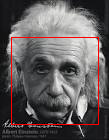

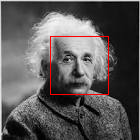

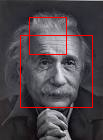

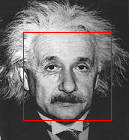

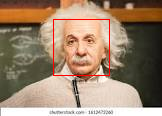

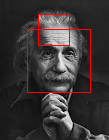

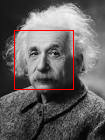

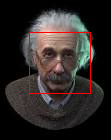

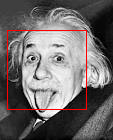

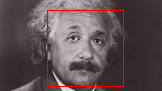

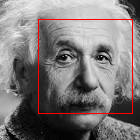

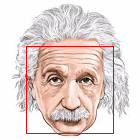

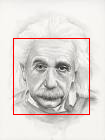

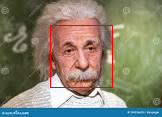

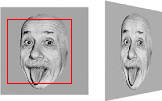

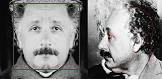

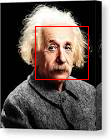

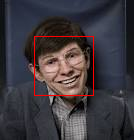

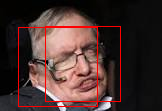

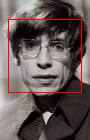

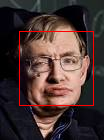

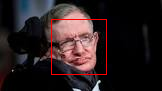

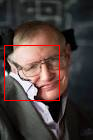

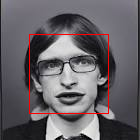

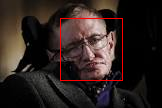

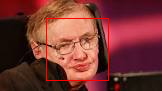

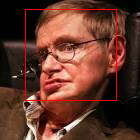

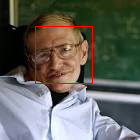

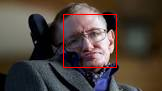

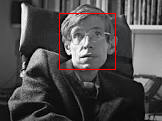

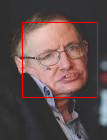

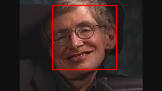

In [20]:
for _, row in true_df.iterrows():
  cv2_imshow(row[0])

#### Step 2: face recognition

Now that we detected Einstein's and Hawking's faces over a bunch of web scrapped images, we were able to build a small dataset that we can use to train a face recognizer. The chosen model was LBPH (Local Binary Patterns Histogram).

In [21]:
recognizer = cv2.face.LBPHFaceRecognizer_create()

face_array = np.array(list(true_df['face']))

label_array = np.array(list(true_df['label']))

recognizer.train(face_array, label_array)

We can build a function to predict faces using the chosen model.

In [22]:
def predict_face(img):

  final_img = face_detector(img)[0]

  prediction = recognizer.predict(face_detector(img)[1])

  if prediction[0] == 1:
    final_label = "Einstein"
  if prediction[0] == 2:
    final_label = "Hawking"

  confidence = prediction[1]

  return [final_label, confidence, final_img]

Let's see if the model can identify Einstein from a video frame.

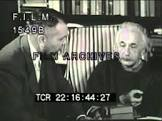

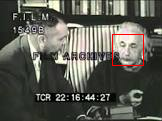

Einstein


In [23]:
url_einstein = 'https://www.google.com/search?q=einstein+video&tbm=isch&sxsrf=APwXEddve3aqSXOMyvejMv9Jqiv8nxrTag:1687479896004&source=lnms&sa=X&ved=2ahUKEwiP_5C-kNj_AhUGH7kGHaAcDp8Q0pQJegQIDRAG&biw=1517&bih=694&dpr=0.9'

recon_list = []

htmldata = getdata(url_einstein)
soup = BeautifulSoup(htmldata, 'html.parser')
img_1 = img_scrap_and_convert(soup.find_all('img')[1]['src'])

cv2_imshow(img_1)

prediction = predict_face(img_1)

cv2_imshow(prediction[2])

print(prediction[0])

Success!

Now let's search for Stephen Hawking, also in a video frame.

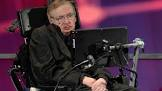

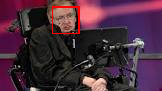

Hawking


In [24]:
url_hawking = 'https://www.google.com/search?q=stephen+hawking+video&tbm=isch&ved=2ahUKEwjd6MaDi9j_AhUXMLkGHdi-B2wQ2-cCegQIABAA&oq=stephen+hawking+video&gs_lcp=CgNpbWcQAzoECCMQJzoHCAAQExCABDoICAAQBxAeEBM6CAgAEAUQHhATOggIABCxAxCDAToECAAQAzoLCAAQgAQQsQMQgwE6BQgAEIAEOggIABCABBCxAzoKCAAQigUQsQMQQzoHCAAQigUQQzoECAAQHjoGCAAQCBAeOgkIABAIEB4QxwNQygRYhhZgyxdoAHAAeACAAY4CiAG9GpIBBjAuMTkuM5gBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=nuCUZN2hO5fg5OUP2P2e4AY&bih=694&biw=1517'

recon_list = []

htmldata = getdata(url_hawking)
soup = BeautifulSoup(htmldata, 'html.parser')
img_2 = img_scrap_and_convert(soup.find_all('img')[1]['src'])

cv2_imshow(img_2)

prediction = predict_face(img_2)

cv2_imshow(prediction[2])

print(prediction[0])

Hawking is also correctly identified! Even with a small training dataset, the LBPH model was able to provide interesting image classifying results.